# Siamese Network with Optuna for Hyperparameter Optimization

### Install dependencies

In [1]:
%cd {HOME}

!python -m pip install opencv-python matplotlib tensorflow==2.10 

[WinError 2] 系統找不到指定的檔案。: '{HOME}'
d:\Code\CowId\notebooks


In [2]:
!conda install -c conda-forge cudatoolkit=11.8.0 --yes

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.3.1




In [3]:
!pip install nvidia-cudnn-cu11==8.6.0.163 --yes


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes


In [4]:
!CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib

'CUDNN_PATH' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'export' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [5]:
# Check CPU
!python -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

tf.Tensor(-1860.0593, shape=(), dtype=float32)


2023-05-17 22:34:31.479843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 22:34:32.317420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9392 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
# Check GPU
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
!pip install optuna

### Import dependencies

In [1]:
import os
import cv2
import csv
import time
import random
import optuna
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import backend, layers, metrics, regularizers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

d:\Code\CowId\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.10.0', '1.24.2')

### Set up environment

Set GPU growth to avoid OOM errors

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Set Home path

In [3]:
HOME = os.path.split(os.getcwd())[0]
print(HOME)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

d:\Code\CowId


Set data path

In [4]:
dataset_path = os.path.join(HOME, "data", "siamese_v5_augmented_train_val")

In [5]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

### Helper functions

In [6]:
def read_image(path, target_size=(128, 128)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image

In [7]:
def generate_triplets(output_loc):
    if not os.path.exists(output_loc):
        os.makedirs(output_loc)
    triplets = []
    for cows in os.listdir(dataset_path):
        neg_dir_list = os.listdir(dataset_path)
        neg_dir_list.remove(cows)
        all_cows_except_current = []
        for neg_cows in neg_dir_list:
            neg_list = os.listdir(os.path.join(dataset_path, neg_cows))
            neg_list = list(map(lambda x: os.path.join(dataset_path, neg_cows, x), neg_list))
            all_cows_except_current = all_cows_except_current + neg_list
        path_to_cow = os.path.join(dataset_path, cows)
        print(path_to_cow)
        if "cow" in path_to_cow:
            pos_list = os.listdir(os.path.join(dataset_path,cows))
            pos_list = list(map(lambda x: os.path.join(dataset_path, cows, x), pos_list))
            while len(pos_list) > 1 and len(neg_list) > 0:
                rand_pos_index = random.randrange(len(pos_list)) 
                positive_elem = pos_list.pop(rand_pos_index)
                rand_anc_index = random.randrange(len(pos_list))
                anchor_elem = pos_list.pop(rand_anc_index)
                rand_neg_index = random.randrange(len(neg_list))
                neg_elem = neg_list.pop(rand_neg_index)
                triplets.append((positive_elem,anchor_elem,neg_elem))  
    print(len(triplets))
    with open(os.path.join(output_loc, 'triplets.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        for row in triplets:
            writer.writerow(row)

In [8]:
def split_dataset(saving_route, percentage=0.2):
    dataset = []
    with open(os.path.join(saving_route, 'triplets.csv'), newline='') as file:
        reader = csv.reader(file)
        for row in reader:
            dataset.append(row)
    n = len(dataset)
    split_point = int(n * percentage)
    random.shuffle(dataset)
    train_set = dataset[:split_point] 
    test_set = dataset[split_point:]
    return train_set, test_set

In [9]:
def get_batch(triplet_list, batch_size=64, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

In [10]:
def get_encoder(input_shape):

    pretrained_model = ResNet152(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-12):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [11]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [12]:
def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoded_a,
        encoded_p,
        encoded_n
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

In [13]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [14]:
def test_on_triplets(val_triplets, siamese_model, batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(val_triplets, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [15]:
def plot_metrics(loss, metrics, dir):
    plt.clf()
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    plt.savefig(os.path.join(dir, 'Loss.png'))
    plt.clf()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    plt.savefig(os.path.join(dir, 'Accuracy.png'))
    
    plt.figure(figsize=(15,5))
    plt.clf()
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()
    plt.savefig(os.path.join(dir, 'metrics.png'))
    plt.clf()

In [16]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

In [17]:
def classify_images(encoder, cows_list1, cows_list2, threshold=0.5):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(cows_list1)
    tensor2 = encoder.predict(cows_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    print(prediction)
    return prediction

In [18]:
def ModelMetrics(pos_list, neg_list, dir):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.clf()
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.savefig(os.path.join(dir, 'confusion_matrix.png'))
    plt.clf()
    return accuracy_score(true, pred), f1_score(true, pred)

In [19]:
def preprocess(img):
    img = tf.image.resize(img, (128,128))
    img = img / 255.0
    return img

In [20]:
def classify_image(encoder, cow1, cow2, threshold=0.5):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(np.array([cow1]))
    tensor2 = encoder.predict(np.array([cow2]))
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    return distance[0]

In [21]:
saving_route = os.path.join(HOME, 'data', 'siamese_triplets_lists')

generate_triplets(saving_route)

train_triplets, val_triplets = split_dataset(saving_route, 0.2)

d:\Code\CowId\data\siamese_v5_augmented\cow_1
d:\Code\CowId\data\siamese_v5_augmented\cow_10
d:\Code\CowId\data\siamese_v5_augmented\cow_2
d:\Code\CowId\data\siamese_v5_augmented\cow_3
d:\Code\CowId\data\siamese_v5_augmented\cow_4
d:\Code\CowId\data\siamese_v5_augmented\cow_5
d:\Code\CowId\data\siamese_v5_augmented\cow_6
d:\Code\CowId\data\siamese_v5_augmented\cow_7
d:\Code\CowId\data\siamese_v5_augmented\cow_8
d:\Code\CowId\data\siamese_v5_augmented\cow_9
d:\Code\CowId\data\siamese_v5_augmented\negatives
10269


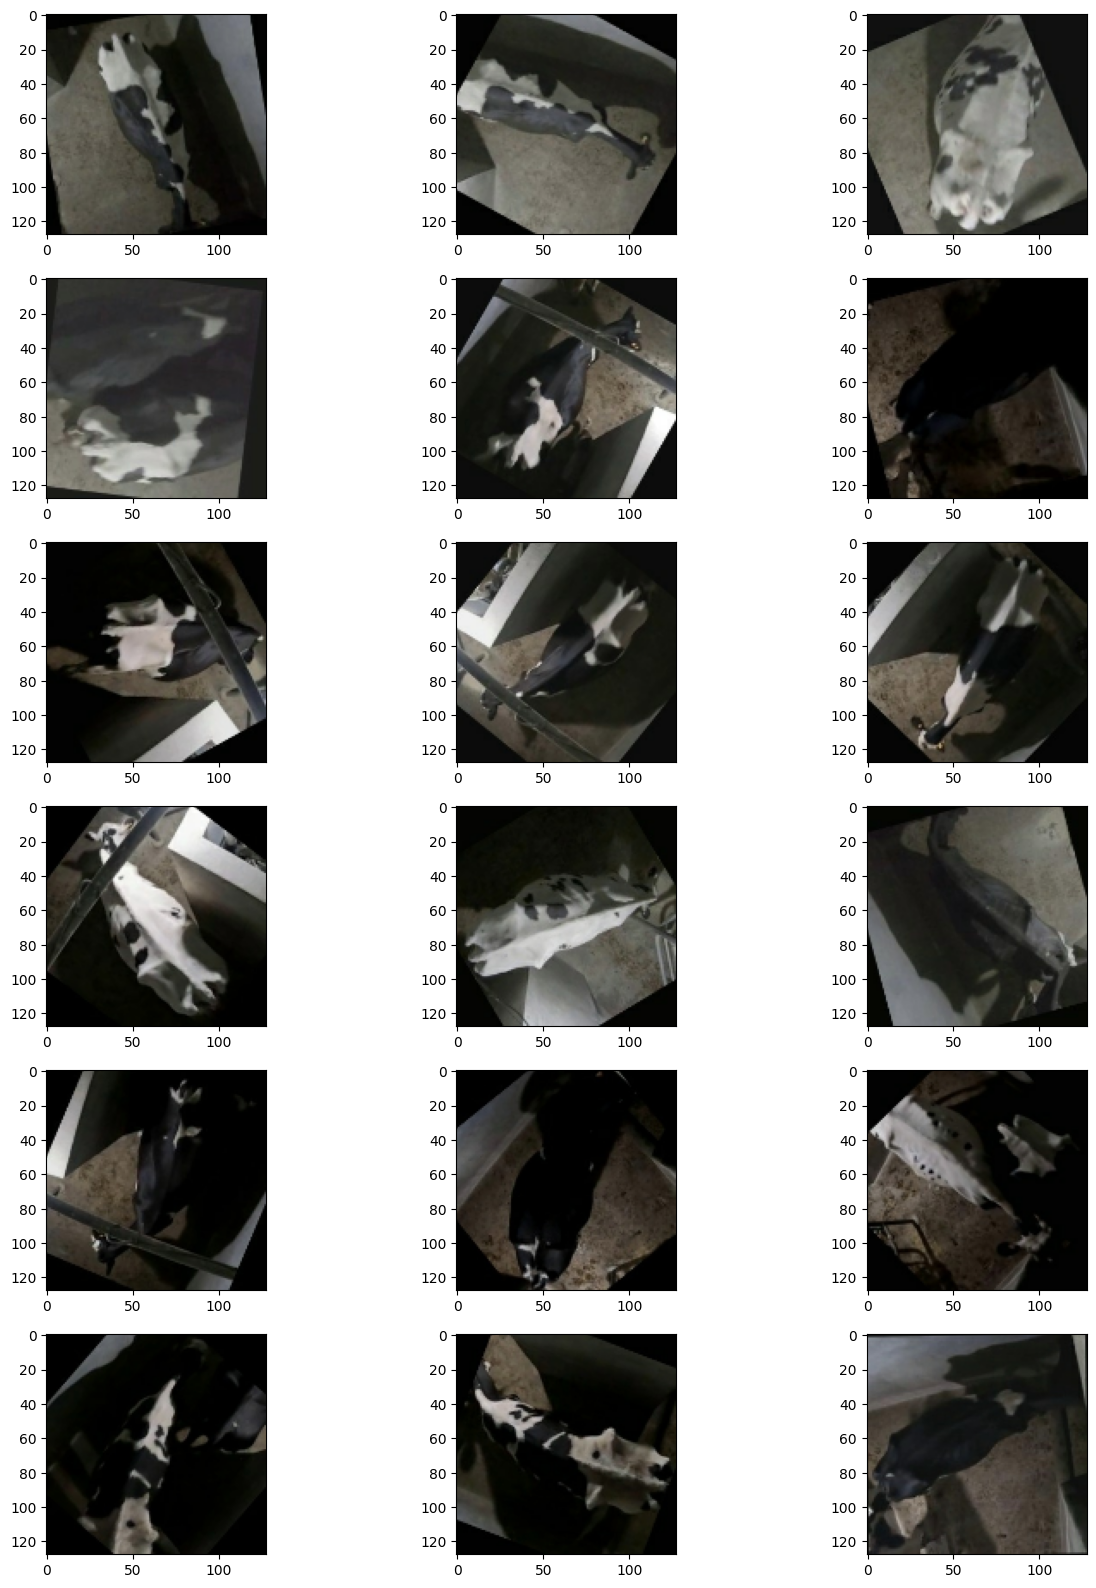

In [22]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplets, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
    break

In [23]:
store_folder = 'optuna_siamese_resnet'

folder_names = [int(name) for name in os.listdir(os.path.join(HOME, 'data', store_folder)) if os.path.isdir(os.path.join(HOME, 'data', store_folder, name))]
sorted_folders = sorted(folder_names, reverse=True)

OPTUNA_RUN_ITERATION = 0 if len(sorted_folders) == 0 else sorted_folders[0]

def objective(trial):
    global OPTUNA_RUN_ITERATION
    OPTUNA_RUN_ITERATION += 1
    OPTUNA_DIR = os.path.join(HOME, 'data', store_folder, str(OPTUNA_RUN_ITERATION))

    if not os.path.exists(os.path.join(HOME, 'data', OPTUNA_DIR)):
        os.makedirs(os.path.join(HOME, 'data', OPTUNA_DIR))

    param_grid = {"LR": trial.suggest_int("LR", -4, -4, step=1), 
                  'E': trial.suggest_int("E", -2, -2, step=1), 
                  'EPOCHS': trial.suggest_int("EPOCHS", 100, 100, step=10),
                  'BATCH_SIZE': trial.suggest_int("BATCH_SIZE", 32, 32, step=32)}

    LR = 10**param_grid["LR"]
    E = 10**param_grid["E"]
    EPOCHS = param_grid["EPOCHS"]
    BATCH_SIZE = param_grid["BATCH_SIZE"]

    with open(os.path.join(HOME, 'data', OPTUNA_DIR, 'params.json'), 'w') as f:
        json.dump(param_grid, f)

    save_all = False

    siamese_network = get_siamese_network()
    siamese_model = SiameseModel(siamese_network)
    initial_learning_rate = LR
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate,
    #     decay_steps=100000,
    #     decay_rate=0.96,
    #     staircase=True)

    optimizer = Adam(learning_rate=LR, epsilon=E)
    siamese_model.compile(optimizer=optimizer)

    max_acc = 0
    train_loss = []
    test_metrics = []

    for epoch in range(1, EPOCHS+1):
        t = time.time()
        print(f"Started training EPOCH {epoch}")
        
        # Training the model on train data
        epoch_loss = []
        for data in get_batch(train_triplets, batch_size=BATCH_SIZE):
            loss = siamese_model.train_on_batch(data)
            epoch_loss.append(loss)
        epoch_loss = sum(epoch_loss)/len(epoch_loss)
        train_loss.append(epoch_loss)

        print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
        print(f"Loss on train    = {epoch_loss:.5f}")
        
        # Testing the model on test data
        metric = test_on_triplets(val_triplets, siamese_model, batch_size=BATCH_SIZE)
        test_metrics.append(metric)
        accuracy = metric[0]
        
        # Saving the model weights
        if save_all or accuracy>=max_acc:
            siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model"))
            max_acc = accuracy

    # Saving the model after all epochs run
    siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model-final"))

    test_metrics = np.array(test_metrics)
    plot_metrics(train_loss, test_metrics, os.path.join(OPTUNA_DIR))

    encoder = extract_encoder(siamese_model)
    encoder.save_weights(os.path.join(OPTUNA_DIR, "encoder"))

    pos_list = np.array([])
    neg_list = np.array([])

    for data in get_batch(val_triplets, batch_size=64):
        a, p, n = data
        pos_list = np.append(pos_list, classify_images(encoder, a, p, 0.3))
        neg_list = np.append(neg_list, classify_images(encoder, a, n, 0.3))

    model_accuracy, model_f1 = ModelMetrics(pos_list, neg_list, os.path.join(OPTUNA_DIR))

    encoder.save(os.path.join(OPTUNA_DIR, 'siamese_model.h5'))

    return model_accuracy, model_f1


[I 2023-05-19 15:14:00,991] A new study created in RDB with name: no-name-a02eb172-a41b-4a42-9baa-83cf985b9115


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 53 sec)
Loss on train    = 0.89779
1/1 [==============================] - 4s 4s/step
Accuracy on test = 0.71775
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 10 sec)
Loss on train    = 0.61891
1/1 [==============================] - 0s 46ms/step
Accuracy on test = 0.74623
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 10 sec)
Loss on train    = 0.57106
1/1 [==============================] - 0s 50ms/step
Accuracy on test = 0.75195
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 10 sec)
Loss on train    = 0.54106
1/1 [==============================] - 0s 40ms/step
Accuracy on test = 0.75779
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 10 sec)
Loss on train    = 0.50561
1/1 [==============================] - 0s 51ms/step
Accuracy on test = 0.76278
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 10 sec)
Loss on train    = 0.48225
1/1 [==============================] - 0s 44ms/step
Accuracy on test = 0.76254
Starte

[I 2023-05-19 17:14:46,347] Trial 0 finished with values: [0.6040652385589095, 0.712860799717539] and parameters: {'LR': -4, 'E': -2, 'EPOCHS': 100, 'BATCH_SIZE': 32}. 


<Figure size 640x480 with 0 Axes>

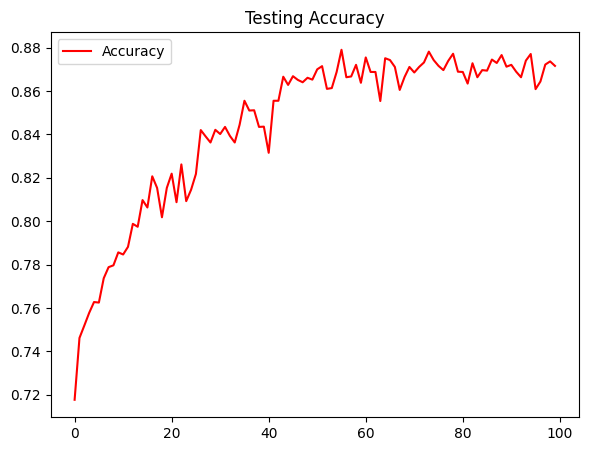

<Figure size 1500x500 with 0 Axes>

In [24]:
# Select to maximize or minimize parameters
study = optuna.create_study(directions=['maximize', 'maximize'], storage=f"sqlite:///{os.path.join(HOME, 'data', 'siamese_v6.db')}", load_if_exists=True)
study.optimize(objective, n_trials=1)

In [29]:
# Save the parameters
import pickle

# save the list to a file
with open(os.path.join(HOME, 'data', 'trials.pickle'), 'wb') as f:
    pickle.dump(study.best_trials, f)

## Prediction on test set

In [1]:
import csv
import os
import cv2
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import datetime

from ultralytics import YOLO
from PIL import Image
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
HOME = os.path.split(os.getcwd())[0]
print(HOME)

d:\Code\CowId


In [3]:

class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [4]:
def classify_images(encoder, cows_list1, cows_list2, threshold=0.5):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(cows_list1)
    tensor2 = encoder.predict(cows_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    print(prediction)
    return prediction

In [5]:
def classify_image(encoder, cow1, cow2):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(np.array([cow1]))
    tensor2 = encoder.predict(np.array([cow2]))
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    return distance[0]

In [6]:
def get_batch(tuples_list, batch_size=64, preprocess=True):
    batch_steps = len(tuples_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        comparison = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(tuples_list):
            a, c = tuples_list[j]
            anchor.append(read_image(a))
            comparison.append(read_image(c))
            j+=1
            
        anchor = np.array(anchor)
        comparison = np.array(comparison)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            comparison = preprocess_input(comparison)
        
        yield ([anchor, comparison])

In [7]:
def generate_pairs(output_loc, test_dataset_path):
    pos_pairs, neg_pairs = [], []
    for cows in os.listdir(test_dataset_path):
        neg_dir_list = os.listdir(test_dataset_path)
        neg_dir_list.remove(cows)
        all_cows_except_current = []
        for neg_cows in neg_dir_list:
            neg_list = os.listdir(os.path.join(test_dataset_path, neg_cows))
            neg_list = [os.path.join(test_dataset_path, neg_cows, x) for x in neg_list]
            all_cows_except_current += neg_list
        path_to_cow = os.path.join(test_dataset_path, cows)
        print(path_to_cow)
        if "cow" in path_to_cow:
            pos_list = os.listdir(os.path.join(test_dataset_path, cows))
            pos_list = [os.path.join(test_dataset_path, cows, x) for x in pos_list]
            anchor_image = os.path.join(path_to_cow, 'anchor.jpg')
            pos_pairs += [(anchor_image, x) for x in pos_list if x != anchor_image]
            neg_pairs += [(anchor_image, x) for x in all_cows_except_current]
    print(len(pos_pairs), len(neg_pairs))
    with open(os.path.join(output_loc, 'pos_pairs.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        for row in pos_pairs:
            writer.writerow(row)
    with open(os.path.join(output_loc, 'neg_pairs.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        for row in neg_pairs:
            writer.writerow(row)


In [8]:
def read_image(path, target_size=(128, 128)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image

In [9]:
def save_params(params, filename):
    """Saves parameters to a json file"""
    with open(filename, 'w') as json_file:
        json.dump(params, json_file, indent=4)

In [10]:
def load_siamese_model(model_location):
    """Load a pre-trained model"""
    return tf.keras.models.load_model(
        os.path.join(model_location, 'siamese_model.h5'), 
        custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [11]:
def load_yolo_model(model_location):
    """Load a pre-trained model"""
    return YOLO(model_location)

In [12]:
def create_dir(base_folder, iteration):
    """Creates a new directory for storing data"""
    new_dir = os.path.join(HOME, 'data', base_folder, str(iteration))
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    return new_dir

In [13]:
def get_next_iteration(base_folder):
    """Determines the next iteration number based on existing directories"""
    folder_names = [
        int(name) for name in os.listdir(os.path.join(HOME, 'data', base_folder))
        if os.path.isdir(os.path.join(HOME, 'data', base_folder, name))
    ]
    return 0 if len(folder_names) == 0 else max(folder_names) + 1

In [14]:
def read_dataset(file_path):
    """Reads a dataset from a csv file and returns it as a list"""
    with open(file_path, newline='') as file:
        return list(csv.reader(file))

In [15]:
def classify_data(dataset, model, batch_size, threshold=0.5):
    """Classifies images using the siamese model"""
    result = np.array([])
    for data in get_batch(dataset, batch_size=batch_size):
        a, c = data
        result = np.append(result, classify_images(model, a, c, threshold))
    return result

In [16]:
def plot_confusion_matrix(true, pred, siamese_dir):
    """Computes and plots the confusion matrix"""
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.clf()
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.savefig(os.path.join(siamese_dir, 'confusion_matrix.png'))
    plt.clf()

In [17]:
def expand_rectangle_to_square(x1, y1, x2, y2):
    width = abs(x2 - x1)
    height = abs(y2 - y1)
    size = max(width, height)
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    new_x1 = center_x - size / 2
    new_y1 = center_y - size / 2
    new_x2 = center_x + size / 2
    new_y2 = center_y + size / 2
    return new_x1, new_y1, new_x2, new_y2

In [18]:
def crop_to_square(image, x1, y1, x2, y2):
    cropped_image = Image.fromarray(image).crop((x1, y1, x2, y2)).resize((128, 128))
    return cropped_image

In [38]:
def verify(model, input_image, db_loc, detection_threshold):
    # Build results array
    best = detection_threshold
    cow = "None"
    numpy_array = np.array(input_image)
    input_img = tf.convert_to_tensor(numpy_array, dtype=tf.float32)
    best_val_img = None
    
    for image in os.listdir(db_loc):
        byte_img = tf.io.read_file(os.path.join(db_loc, image))
        img = tf.io.decode_jpeg(byte_img)
        img = tf.image.resize(img, [128, 128])
        
        input_img = preprocess_input(input_img)
        validation_img = preprocess_input(img)

        # fig, (ax1, ax2) = plt.subplots(ncols=2)
        # ax1.imshow(input_image)
        # ax2.imshow(tf.io.decode_jpeg(byte_img))
        # plt.savefig(os.path.join(HOME, 'data', 'a.png'))
        
        # print("IMAGE TYPES")
        # print(type(input_img), type(validation_img))
        # print(input_img.shape, validation_img.shape)
        # return "", 0, "", ""
        # Make Predictions 
        distance = classify_image(model, input_img, validation_img)
        if distance < detection_threshold and distance < best:
            best = distance
            cow = image
            best_val_img = tf.io.decode_jpeg(byte_img)
    return cow, best, input_image, best_val_img

In [34]:
def seconds_to_time(seconds):
    td = datetime.timedelta(seconds=seconds)
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    time_str = f'{hours:02}:{minutes:02}:{seconds:02}'
    
    return time_str

In [39]:
params = {
    "STORE_FOLDER": "siamese_runs",
    "TEST_DATASET_PATH": os.path.join(HOME, "data", "siamese_v6_test", "test"),
    "SIAMESE_MODEL_LOC": os.path.join(HOME, "data", "optuna_siamese_resnet", "31"),
    "YOLO_MODEL_LOC": os.path.join(HOME, "data", "yolo_models", "train11", "weights", "best.pt"),
    "VIDEO_INPUT_LOC": os.path.join(HOME, "data", "video_cc_1.mp4"),
    "VIDEO_TEST_COWS_LOC": os.path.join(HOME, "data", "siamese_v6_test", "test", "video_test"),
    "THRESHOLD": 0.2
}

siamese_model = load_siamese_model(params["SIAMESE_MODEL_LOC"])
yolo_model = load_yolo_model(params["YOLO_MODEL_LOC"])
siamese_run_iteration = get_next_iteration(params["STORE_FOLDER"])
siamese_dir = create_dir(params["STORE_FOLDER"], siamese_run_iteration)

def create_test_metrics():
    generate_pairs(siamese_dir, params["TEST_DATASET_PATH"])

    save_params(params, os.path.join(siamese_dir, "params.json"))

    pos_dataset = read_dataset(os.path.join(siamese_dir, "pos_pairs.csv"))
    neg_dataset = read_dataset(os.path.join(siamese_dir, "neg_pairs.csv"))

    pos_list = classify_data(pos_dataset, siamese_model, batch_size=256, threshold=params["THRESHOLD"])
    neg_list = classify_data(neg_dataset, siamese_model, batch_size=64, threshold=params["THRESHOLD"])

    # Calculate overall accuracy
    true_overall = np.array([0]*len(pos_list) + [1]*len(neg_list))
    pred_overall = np.append(pos_list, neg_list)
    print(f"Accuracy of model overall: {accuracy_score(true_overall, pred_overall)}")

    # Calculate accuracy for positives
    true_pos = np.array([0]*len(pos_list))
    print(f"Accuracy of model on positives: {accuracy_score(true_pos, pos_list)}")

    # Calculate accuracy for negatives
    true_neg = np.array([1]*len(neg_list))
    print(f"Accuracy of model on negatives: {accuracy_score(true_neg, neg_list)}")

    # Plot confusion matrix
    plot_confusion_matrix(true_overall, pred_overall, siamese_dir)

def create_video_pipiline_results():
    vidcap = cv2.VideoCapture(params["VIDEO_INPUT_LOC"])
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    success = True
    count = 0
    detections = []
    while success:
        success,image = vidcap.read()
        count += 1
        if count % 2 == 0: continue
        image = np.uint8(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        res = yolo_model(image, conf=0.5)
        boxes = res[0].boxes.xyxy.tolist()
        cow_number = 0
        for inner_list in boxes:
            cow_number += 1
            x1, y1, x2, y2 = inner_list
            x1, y1, x2, y2 = expand_rectangle_to_square(x1, y1, x2, y2)
            cropped_image = crop_to_square(image, x1, y1, x2, y2)
            verified_result, distance, cow_a, cow_b = verify(siamese_model, 
                                                             cropped_image, 
                                                             params["VIDEO_TEST_COWS_LOC"], 
                                                             params["THRESHOLD"])
            if verified_result != "None":
                time = seconds_to_time(count/fps)
                detection = f"{verified_result.split('.', 1)[0]} detected at time {time} with distance of {distance}"
                detections.append(detection)
                print(detection)

                fig, (ax1, ax2) = plt.subplots(ncols=2)
                ax1.imshow(cow_a)
                ax2.imshow(cow_b)
                plt.savefig(os.path.join(siamese_dir, f'{time.replace(":", "")}-{distance}.png'))
        
    with open(os.path.join(siamese_dir, 'detection_data.csv'), 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        for row in detections:
            writer.writerow([row])
    return

create_video_pipiline_results()
create_test_metrics()


0: 384x640 (no detections), 41.0ms
Speed: 6.5ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 24.0ms
Speed: 1.0ms preprocess, 24.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 25.0ms
Speed: 1.0ms preprocess, 25.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 

1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 (no detections), 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.2ms
Speed: 0.0ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 0.0m

1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 (no detections), 9.4ms
Speed: 0.0ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 (no detections), 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.5ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 2.5ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.0ms 

1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 (no detections), 5.2ms
Speed: 0.0ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.6ms
Speed: 0.0ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 2.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms 

1/1 [==============================] - 0s 25ms/step



0: 384x640 (no detections), 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.0ms 

1/1 [==============================] - 0s 23ms/step



0: 384x640 (no detections), 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 0.5ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.0ms 

1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 (no detections), 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.2ms
Speed: 0.0ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 

1/1 [==============================] - 0s 21ms/step



0: 384x640 (no detections), 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 3.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 

1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 7.2ms
Speed: 4.0ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 19ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 19ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 13.1ms
Speed: 3.5ms preprocess, 13.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 19ms/step



0: 384x640 (no detections), 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.7ms
Speed: 1.3ms preprocess, 9.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 

1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.6ms
Speed: 0.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.5ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms 

1/1 [==============================] - 0s 20ms/step



0: 384x640 (no detections), 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 0.0ms 

1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 19ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 19.2ms
Speed: 1.0ms preprocess, 19.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 6.5ms
Speed: 3.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 7.6ms
Speed: 1.0ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 19.1ms
Speed: 1.0ms preprocess, 19.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.7ms
Speed: 1.0ms preprocess, 3.7ms inference, 0.5ms 

1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.1ms
Speed: 0.0ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms 

1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 0.5ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 

1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 5.3ms
Speed: 0.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step
anchor_1 detected at time 00:00:43 with distance of 0.08742756396532059



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms 

1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 16.5ms
Speed: 1.5ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.5ms
Speed: 3.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0m

1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 5.1ms
Speed: 0.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 11.8ms
Speed: 0.0ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 17.8ms
Speed: 3.0ms preprocess, 17.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.5ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 16.5ms
Speed: 0.0ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms 

1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 18.5ms
Speed: 1.5ms preprocess, 18.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step
anchor_2 detected at time 00:00:58 with distance of 0.05253021419048309



0: 384x640 1 cow, 4.3ms
Speed: 0.0ms preprocess, 4.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step
anchor_2 detected at time 00:00:58 with distance of 0.04206172376871109



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step
anchor_2 detected at time 00:00:58 with distance of 0.04410149157047272



0: 384x640 1 cow, 4.0ms
Speed: 0.5ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step
anchor_2 detected at time 00:00:58 with distance of 0.09710365533828735



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 20.1ms
Speed: 1.0ms preprocess, 20.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 60.3ms
Speed: 1.0ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 27.5ms
Speed: 1.0ms preprocess, 27.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.3ms
Speed: 1.0ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 12.4ms
Speed: 1.0ms preprocess, 12.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 15.5ms
Speed: 0.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 6.0ms
Speed: 5.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 3.8ms
Speed: 1.0ms preprocess, 3.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 15.8ms
Speed: 1.0ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 15.0ms
Speed: 0.5ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.5ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.3ms
Speed: 0.0ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.5ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 13.6ms
Speed: 0.0ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 15.2ms
Speed: 0.0ms preprocess, 15.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 3.9ms
Speed: 1.0ms preprocess, 3.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.5ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 14.5ms
Speed: 2.0ms preprocess, 14.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 17.2ms
Speed: 1.0ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.1ms
Speed: 1.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms infer

1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.2ms
Speed: 0.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 cows, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.9ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 

1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 1 cow, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 4.0ms
Speed: 1.2ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.1ms
Speed: 0.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 0.0ms 

1/1 [==============================] - 0s 24ms/step



0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms 

1/1 [==============================] - 0s 25ms/step



0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms 

1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.5ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.2ms
Speed: 1.0ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 20ms/step



0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 9.4ms
Speed: 1.0ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 (no detections), 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.1ms
Speed: 0.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.5ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms 

1/1 [==============================] - 0s 21ms/step



0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 (no detections), 6.7ms
Speed: 1.0ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 18.5ms
Speed: 1.0ms preprocess, 18.5ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 4.8ms
Speed: 0.0ms preprocess, 4.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 12.5ms
Speed: 0.0ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 (no detections), 11.7ms
Speed: 1.0ms preprocess, 11.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.5ms
Speed: 0.5ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.0ms po

1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 (no detections), 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 8.4ms
Speed: 1.0ms preprocess, 8.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.5ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 6.5ms
Speed: 3.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 (no detections), 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.2ms
Speed: 1.0ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms 

1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 6.2ms
Speed: 0.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 5.0ms
Speed: 3.3ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 4.1ms
Speed: 1.0ms preprocess, 4.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.2ms
Speed: 1.0ms preprocess, 7.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 12.3ms
Speed: 0.0ms preprocess, 12.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 13.1ms
Speed: 1.0ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 (no detections), 3.8ms
Speed: 0.0ms preprocess, 3.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 21ms/step



0: 384x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.3ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.5ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step
anchor_2 detected at time 00:02:24 with distance of 0.04947328567504883



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step
anchor_2 detected at time 00:02:24 with distance of 0.04335011541843414



0: 384x640 1 cow, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step
anchor_2 detected at time 00:02:24 with distance of 0.06925372779369354



0: 384x640 1 cow, 3.0ms
Speed: 0.8ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step
anchor_2 detected at time 00:02:24 with distance of 0.060594603419303894



0: 384x640 1 cow, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 29.0ms
Speed: 1.0ms preprocess, 29.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 12.8ms
Speed: 1.0ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step
anchor_2 detected at time 00:02:25 with distance of 0.04456447809934616



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step
anchor_2 detected at time 00:02:25 with distance of 0.05687032267451286



0: 384x640 1 cow, 15.4ms
Speed: 0.0ms preprocess, 15.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step
anchor_2 detected at time 00:02:25 with distance of 0.060561612248420715



0: 384x640 1 cow, 6.1ms
Speed: 3.0ms preprocess, 6.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step
anchor_2 detected at time 00:02:25 with distance of 0.04273205250501633


C:\Users\arihs\AppData\Local\Temp\ipykernel_7616\871407817.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(ncols=2)

0: 384x640 1 cow, 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 15.5ms
Speed: 0.0ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 7.3ms
Speed: 0.0ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 (no detections), 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 21.7ms
Speed: 1.0ms preprocess, 21.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.1ms
Speed: 1.0ms preprocess, 14.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.9ms
Speed: 1.0ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.5ms
Speed: 1.5ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms i

1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 (no detections), 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.3ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step
anchor_1 detected at time 00:02:32 with distance of 0.08963372558355331



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 6.1ms
Speed: 0.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 35.6ms
Speed: 1.0ms preprocess, 35.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 13.4ms
Speed: 1.0ms preprocess, 13.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.3ms preprocess, 10.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 28.1ms
Speed: 0.5ms preprocess, 28.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 (no detections), 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.6ms
Speed: 0.0ms preprocess, 13.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inf

1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 8.7ms
Speed: 0.0ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.5ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 (no detections), 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 16.5ms
Speed: 3.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.9ms
Speed: 1.0ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference

1/1 [==============================] - 0s 27ms/step



0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.0ms
Speed: 6.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 12.3ms
Speed: 1.0ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 6.2ms
Speed: 1.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 29.5ms
Speed: 1.0ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 1.1ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.8ms
Speed: 1.0ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.7ms
Speed: 1.0ms preprocess, 13.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 2.5ms preprocess, 10.5ms i

1/1 [==============================] - 0s 26ms/step



0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.5ms
Speed: 3.3ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.1ms
Speed: 0.0ms preprocess, 12.1ms inference

1/1 [==============================] - 0s 27ms/step



0: 384x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.7ms
Speed: 0.0ms preprocess, 5.7ms inference, 1.

1/1 [==============================] - 0s 29ms/step



0: 384x640 (no detections), 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 (no detections), 4.9ms
Speed: 1.6ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms 

1/1 [==============================] - 0s 22ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 8.2ms
Speed: 0.0ms preprocess, 8.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 4.7ms
Speed: 1.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.6ms
Speed: 1.0ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 15.7ms
Speed: 0.0ms preprocess, 15.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 14.1ms
Speed: 1.0ms preprocess, 14.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step
anchor_1 detected at time 00:03:29 with distance of 0.09111658483743668



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 4.6ms
Speed: 0.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 5.2ms
Speed: 0.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 8.9ms
Speed: 1.0ms preprocess, 8.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 (no detections), 40.2ms
Speed: 0.0ms preprocess, 40.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.3ms
Speed: 0.5ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 15.3ms
Speed: 1.0ms preprocess, 15.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.

1/1 [==============================] - 0s 25ms/step



0: 384x640 (no detections), 13.8ms
Speed: 1.0ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 18.6ms
Speed: 1.0ms preprocess, 18.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 13.2ms
Speed: 1.0ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.6ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.5ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 13.3ms
Speed: 1.0ms preprocess, 13.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.3ms
Speed: 1.0ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.5ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 30.5ms
Speed: 0.0ms preprocess, 30.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 3.5ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 1.0ms preprocess, 10.5ms i

1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 32.5ms
Speed: 0.5ms preprocess, 32.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 14.1ms
Speed: 0.0ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 (no detections), 16.0ms
Speed: 1.5ms preprocess, 16.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 28.0ms
Speed: 2.5ms preprocess, 28.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.1ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 9.4ms
Speed: 1.0ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 (no detections), 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.7ms
Speed: 1.5ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.6ms
Speed: 1.5ms preprocess, 8.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 (no detections), 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 16.6ms
Speed: 1.0ms preprocess, 16.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 (no detections), 6.5ms
Speed: 3.5ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 (no detections), 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.8ms
Speed: 1.0ms preprocess, 13.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 13.1ms
Speed: 1.0ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 14.5ms
Speed: 3.5ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 8.2ms
Speed: 1.0ms preprocess, 8.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 12.1ms
Speed: 1.0ms preprocess, 12.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 23ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.1ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.2ms
Speed: 0.0ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 14.1ms
Speed: 1.0ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 (no detections), 15.1ms
Speed: 2.0ms preprocess, 15.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 13.8ms
Speed: 1.0ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 9.5ms
Speed: 0.5ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.3ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 15.5ms
Speed: 0.0ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 15.5ms
Speed: 1.5ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 12.9ms
Speed: 1.0ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 11.2ms
Speed: 1.0ms preprocess, 11.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 14.3ms
Speed: 1.0ms preprocess, 14.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 (no detections), 14.5ms
Speed: 3.5ms preprocess, 14.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 23.2ms
Speed: 0.0ms preprocess, 23.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 25.0ms
Speed: 1.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 25.3ms
Speed: 1.0ms preprocess, 25.3ms i

1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 (no detections), 13.1ms
Speed: 1.5ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 12.7ms
Speed: 1.0ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 13.7ms
Speed: 0.0ms preprocess, 13.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 3.0ms
Speed: 0.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.3ms
Speed: 0.0ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 29.3ms
Speed: 1.0ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.6ms
Speed: 1.0ms preprocess, 12.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 0.5ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.2ms
Speed: 1.0ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.6ms
Speed: 1.0ms preprocess, 14.6ms i

1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 11.8ms
Speed: 1.0ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 13.1ms
Speed: 1.0ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 24ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 25.5ms
Speed: 1.0ms preprocess, 25.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 1 cow, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 25ms/step



0: 384x640 (no detections), 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.7ms
Speed: 1.0ms preprocess, 13.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference

1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.1ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 8.8ms
Speed: 1.2ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 10.0ms
Speed: 1.5ms preprocess, 10.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 (no detections), 14.6ms
Speed: 0.0ms preprocess, 14.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 13.1ms
Speed: 1.0ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 2 cows, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 2 cows, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.4ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 2 cows, 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 15.0ms
Speed: 0.5ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 2 cows, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 2 cows, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 2 cows, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 2 cows, 13.1ms
Speed: 1.0ms preprocess, 13.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 2 cows, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 14.6ms
Speed: 0.0ms preprocess, 14.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 2 cows, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 15.1ms
Speed: 0.0ms preprocess, 15.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 (no detections), 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.4ms
Speed: 1.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 3.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.7ms
Speed: 0.0ms preprocess, 9.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.4ms
Speed: 1.0ms preprocess, 9.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 0.

1/1 [==============================] - 0s 34ms/step



0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.1ms
Speed: 0.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.3ms
Speed: 1.0ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0m

1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 (no detections), 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.4ms
Speed: 1.0ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference

1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 13.8ms
Speed: 0.0ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.3ms
Speed: 1.0ms preprocess, 10.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.2ms
Speed: 1.0ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 

1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 (no detections), 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.1ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0m

1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.3ms
Speed: 1.0ms preprocess, 8.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 15.1ms
Speed: 3.5ms preprocess, 15.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inferen

1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 1.5ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.2ms
Speed: 1.0ms preprocess, 11.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.3ms preprocess, 7.0ms infer

1/1 [==============================] - 0s 31ms/step



0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 9.8ms
Speed: 0.0ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 1 cow, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 13.1ms
Speed: 1.5ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 15.1ms
Speed: 0.0ms preprocess, 15.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 8.1ms
Speed: 1.1ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 28.1ms
Speed: 0.0ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 (no detections), 8.0ms
Speed: 0.5ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.8ms
Speed: 1.4ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.6ms
Speed: 1.0ms preprocess, 14.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 16.5ms
Speed: 0.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 2 cows, 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 2 cows, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 2 cows, 13.1ms
Speed: 1.0ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step
anchor_2 detected at time 00:04:46 with distance of 0.09703978896141052
1/1 [==============================] - 0s 43ms/step
anchor_2 detected at time 00:04:46 with distance of 0.07259472459554672



0: 384x640 2 cows, 65.1ms
Speed: 1.5ms preprocess, 65.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 5.1ms
Speed: 0.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 2 cows, 17.1ms
Speed: 0.0ms preprocess, 17.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 2 cows, 19.8ms
Speed: 1.0ms preprocess, 19.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 2 cows, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 2 cows, 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 2 cows, 9.8ms
Speed: 1.0ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 2 cows, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 2 cows, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 27ms/step



0: 384x640 2 cows, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 2 cows, 8.6ms
Speed: 1.0ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 2 cows, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 2 cows, 7.0ms
Speed: 0.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 2 cows, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 2 cows, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 2 cows, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 26ms/step



0: 384x640 2 cows, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 2 cows, 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 2 cows, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 2 cows, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 2 cows, 14.5ms
Speed: 2.5ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 14.1ms
Speed: 1.1ms preprocess, 14.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 13.1ms
Speed: 1.0ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 (no detections), 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 (no detections), 12.7ms
Speed: 1.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.7ms
Speed: 0.0ms preprocess, 13.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.0ms
Speed: 1.1ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.1ms preprocess, 9.5ms inference, 0.

1/1 [==============================] - 0s 34ms/step



0: 384x640 (no detections), 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.0ms postproces

1/1 [==============================] - 0s 37ms/step



0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 17.5ms
Speed: 1.5ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 15.5ms
Speed: 0.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.

1/1 [==============================] - 0s 34ms/step



0: 384x640 (no detections), 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.4ms
Speed: 1.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 24.0ms
Speed: 1.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.0ms
Speed: 1.0ms preprocess, 13.0ms inferen

1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 6.7ms
Speed: 1.0ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.4ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 15.6ms
Speed: 4.0ms preprocess, 15.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 8.8ms
Speed: 1.4ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 7.2ms
Speed: 0.0ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 7.0ms
Speed: 4.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 13.9ms
Speed: 0.0ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.5ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 10.2ms
Speed: 1.5ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 8.7ms
Speed: 1.0ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 14.1ms
Speed: 1.0ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 7.4ms
Speed: 0.0ms preprocess, 7.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 15.5ms
Speed: 0.0ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 28.8ms
Speed: 1.0ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 12.1ms
Speed: 1.5ms preprocess, 12.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 7.3ms
Speed: 1.0ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 14.7ms
Speed: 0.0ms preprocess, 14.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 9.8ms
Speed: 1.0ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 13.8ms
Speed: 0.0ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 29ms/step



0: 384x640 1 cow, 21.0ms
Speed: 1.0ms preprocess, 21.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 14.5ms
Speed: 2.0ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 15.1ms
Speed: 1.5ms preprocess, 15.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 11.0ms
Speed: 1.5ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 0.5ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.6m

1/1 [==============================] - 0s 38ms/step



0: 384x640 (no detections), 10.6ms
Speed: 0.0ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 7.6ms
Speed: 0.0ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 12.5ms
Speed: 3.1ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 12.8ms
Speed: 1.0ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.2ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 27.0ms
Speed: 1.0ms preprocess, 27.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 6.6ms
Speed: 0.0ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 8.8ms
Speed: 0.5ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 9.0ms
Speed: 0.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 14.8ms
Speed: 0.0ms preprocess, 14.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 12.0ms
Speed: 1.5ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 10.0ms
Speed: 1.1ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 15.1ms
Speed: 2.5ms preprocess, 15.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 7.2ms
Speed: 0.0ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 9.2ms
Speed: 1.0ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 11.1ms
Speed: 0.0ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 29.3ms
Speed: 1.0ms preprocess, 29.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 45.1ms
Speed: 1.0ms preprocess, 45.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 2 cows, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 14.7ms
Speed: 1.0ms preprocess, 14.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 16.0ms
Speed: 0.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 10.1ms
Speed: 0.0ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 9.0ms
Speed: 3.5ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 11.0ms
Speed: 2.6ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 49ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 9.5ms
Speed: 2.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 (no detections), 13.5ms
Speed: 1.5ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 (no detections), 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.1ms
Speed: 1.0ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 20.1ms
Speed: 0.0ms preprocess, 20.1ms inference

1/1 [==============================] - 0s 30ms/step



0: 384x640 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 (no detections), 8.8ms
Speed: 1.0ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.7ms
Speed: 1.0ms preprocess, 8.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.2ms
Speed: 1.0ms preprocess, 11.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 3.5ms preprocess, 7.0ms inference, 1.5m

1/1 [==============================] - 0s 51ms/step



0: 384x640 1 cow, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 16.7ms
Speed: 0.0ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 1.0ms post

1/1 [==============================] - 0s 40ms/step



0: 384x640 (no detections), 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.9ms
Speed: 1.0ms preprocess, 9.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.9ms
Speed: 1.0ms preprocess, 14.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0m

1/1 [==============================] - 0s 40ms/step



0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.2ms
Speed: 0.0ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.0ms
Speed: 1.5ms preprocess, 10.0ms inference, 

1/1 [==============================] - 0s 32ms/step



0: 384x640 (no detections), 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.5m

1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 7.6ms
Speed: 1.0ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 (no detections), 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 (no detections), 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.2ms
Speed: 1.0ms preprocess, 13.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 31.5ms
Speed: 0.0ms preprocess, 31.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 

1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 10.7ms
Speed: 3.5ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 1 cow, 8.1ms
Speed: 0.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0m

1/1 [==============================] - 0s 40ms/step



0: 384x640 (no detections), 13.5ms
Speed: 2.5ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 28.3ms
Speed: 1.0ms preprocess, 28.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.6ms
Speed: 0.0ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 

1/1 [==============================] - 0s 41ms/step



0: 384x640 (no detections), 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.4ms
Speed: 0.0ms preprocess, 11.4ms inference, 0.0m

1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 1 cow, 6.1ms
Speed: 3.0ms preprocess, 6.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 (no detections), 14.1ms
Speed: 1.0ms preprocess, 14.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 20.3ms
Speed: 2.0ms preprocess, 20.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 48.9ms
Speed: 1.0ms preprocess, 48.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 (no detections), 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 (no detections), 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 (no detections), 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 28ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 10.7ms
Speed: 1.0ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.5ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 49ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 53ms/step



0: 384x640 1 cow, 25.6ms
Speed: 1.0ms preprocess, 25.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postproces

1/1 [==============================] - 0s 31ms/step



0: 384x640 (no detections), 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 (no detections), 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 17.5ms
Speed: 0.5ms preprocess, 17.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 0.0m

1/1 [==============================] - 0s 43ms/step



0: 384x640 (no detections), 8.5ms
Speed: 3.5ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 13.2ms
Speed: 1.0ms preprocess, 13.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 49ms/step



0: 384x640 1 cow, 10.9ms
Speed: 1.0ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 52ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.9ms
Speed: 1.0ms preprocess, 13.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.2ms
Speed: 1.0ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.2ms
Speed: 1.5ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inferen

1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 31ms/step



0: 384x640 1 cow, 28.4ms
Speed: 1.0ms preprocess, 28.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 52ms/step



0: 384x640 1 cow, 9.7ms
Speed: 1.0ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.6ms
Speed: 1.0ms preprocess, 8.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0m

1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 (no detections), 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 17.5ms
Speed: 1.5ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 17.0ms
Speed: 0.0ms preprocess, 17.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.9ms
Speed: 1.0ms preprocess, 7.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 

1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 30ms/step



0: 384x640 1 cow, 12.6ms
Speed: 1.0ms preprocess, 12.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 53ms/step



0: 384x640 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.7ms
Speed: 1.0ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.3ms
Speed: 1.0ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 0.0m

1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 9.0ms
Speed: 4.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 13.9ms
Speed: 1.0ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 11.5ms
Speed: 3.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 6.6ms
Speed: 0.0ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 2 cows, 11.8ms
Speed: 1.0ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 40ms/step



0: 384x640 1 cow, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 6.6ms
Speed: 1.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 15.1ms
Speed: 0.9ms preprocess, 15.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 49ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 14.6ms
Speed: 1.0ms preprocess, 14.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 55ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 54ms/step



0: 384x640 1 cow, 16.1ms
Speed: 1.5ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 63ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 55ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 57ms/step



0: 384x640 (no detections), 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 3.0ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 30.0ms
Speed: 1.0ms preprocess, 30.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.1ms
Speed: 1.0ms preprocess, 14.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 56ms/step



0: 384x640 (no detections), 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.4ms
Speed: 0.0ms preprocess, 8.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.7ms
Speed: 1.0ms preprocess, 7.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.3ms
Speed: 1.0ms preprocess, 8.3ms inference, 0.0ms 

1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 16.0ms
Speed: 0.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 41ms/step



0: 384x640 (no detections), 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 14.0ms
Speed: 3.2ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 7.1ms
Speed: 0.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 13.4ms
Speed: 1.6ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 52ms/step



0: 384x640 1 cow, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 56ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 54ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.5ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 7.7ms
Speed: 1.0ms preprocess, 7.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 54ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.5ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 42ms/step



0: 384x640 1 cow, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 25.7ms
Speed: 1.0ms preprocess, 25.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 55ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 14.5ms
Speed: 0.0ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 54ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 57ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 36ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 56ms/step



0: 384x640 1 cow, 12.6ms
Speed: 1.0ms preprocess, 12.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 57ms/step



0: 384x640 1 cow, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 55ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 55ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 15.8ms
Speed: 1.1ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 54ms/step



0: 384x640 1 cow, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 1 cow, 13.8ms
Speed: 1.0ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 54ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 11.5ms
Speed: 2.5ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 54ms/step



0: 384x640 1 cow, 9.5ms
Speed: 0.5ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 (no detections), 25.3ms
Speed: 1.0ms preprocess, 25.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.3ms
Speed: 1.0ms preprocess, 13.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 0.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 3.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 

1/1 [==============================] - 0s 53ms/step



0: 384x640 (no detections), 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 10.5ms
Speed: 0.0ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 9.2ms
Speed: 1.0ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 13.5ms
Speed: 4.3ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 54ms/step



0: 384x640 (no detections), 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 54ms/step



0: 384x640 (no detections), 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 11.1ms
Speed: 2.0ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 53ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 54ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 9.1ms
Speed: 0.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 54ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 43ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 56ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 15.5ms
Speed: 0.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 9.5ms
Speed: 3.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 55ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.2ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 12.6ms
Speed: 0.0ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 12.2ms
Speed: 1.0ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 39ms/step



0: 384x640 1 cow, 10.0ms
Speed: 1.5ms preprocess, 10.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 49ms/step



0: 384x640 1 cow, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 1 cow, 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 55ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 49ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 7.3ms
Speed: 1.0ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 53ms/step



0: 384x640 1 cow, 14.7ms
Speed: 1.0ms preprocess, 14.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 49ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 37ms/step



0: 384x640 1 cow, 15.1ms
Speed: 0.0ms preprocess, 15.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 56ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 57ms/step



0: 384x640 1 cow, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 56ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 52ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 35ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 9.0ms
Speed: 1.4ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 53ms/step



0: 384x640 1 cow, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 13.9ms
Speed: 1.0ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 33ms/step



0: 384x640 1 cow, 11.5ms
Speed: 3.5ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 32ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 49ms/step



0: 384x640 1 cow, 9.3ms
Speed: 0.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 57ms/step



0: 384x640 1 cow, 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 34ms/step



0: 384x640 1 cow, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 (no detections), 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 56ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 38ms/step



0: 384x640 1 cow, 12.6ms
Speed: 1.0ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 11.1ms
Speed: 1.0ms preprocess, 11.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 14.7ms
Speed: 3.0ms preprocess, 14.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 45ms/step



0: 384x640 2 cows, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 7.5ms
Speed: 0.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 2 cows, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 2 cows, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 2 cows, 11.9ms
Speed: 0.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 9.1ms
Speed: 1.0ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 8.8ms
Speed: 1.0ms preprocess, 8.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 46ms/step



0: 384x640 1 cow, 8.0ms
Speed: 3.5ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 10.0ms
Speed: 1.5ms preprocess, 10.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 52ms/step



0: 384x640 1 cow, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 53ms/step



0: 384x640 1 cow, 12.5ms
Speed: 1.0ms preprocess, 12.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 52ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 49ms/step



0: 384x640 1 cow, 9.2ms
Speed: 1.0ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 48ms/step



0: 384x640 1 cow, 8.1ms
Speed: 1.0ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 50ms/step



0: 384x640 1 cow, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 1 cow, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 51ms/step



0: 384x640 1 cow, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 52ms/step



0: 384x640 1 cow, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 52ms/step



0: 384x640 1 cow, 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 1 cow, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 52ms/step



0: 384x640 1 cow, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 [==============================] - 0s 52ms/step



0: 384x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.5ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 6.4ms
Speed: 1.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0m

d:\Code\CowId\data\siamese_v6_test\test\cow_1
d:\Code\CowId\data\siamese_v6_test\test\cow_2
d:\Code\CowId\data\siamese_v6_test\test\cow_3
d:\Code\CowId\data\siamese_v6_test\test\cow_4
d:\Code\CowId\data\siamese_v6_test\test\cow_5
d:\Code\CowId\data\siamese_v6_test\test\cow_6
d:\Code\CowId\data\siamese_v6_test\test\cow_7
d:\Code\CowId\data\siamese_v6_test\test\cow_8
d:\Code\CowId\data\siamese_v6_test\test\negatives
d:\Code\CowId\data\siamese_v6_test\test\video_test
741 7467
8/8 [==============================] - 0s 33ms/step
[1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 